Checkpoint loaded. Keys: ['model', 'optimizer', 'epoch']
ResNet18 model successfully loaded from checkpoint and ready for use.
Epoch: 19

=== Training History ===
Training history not available in checkpoint

=== Single Image Prediction ===
Testing prediction on: dog.jpg
Predicted class: dog
Confidence: 94.58%


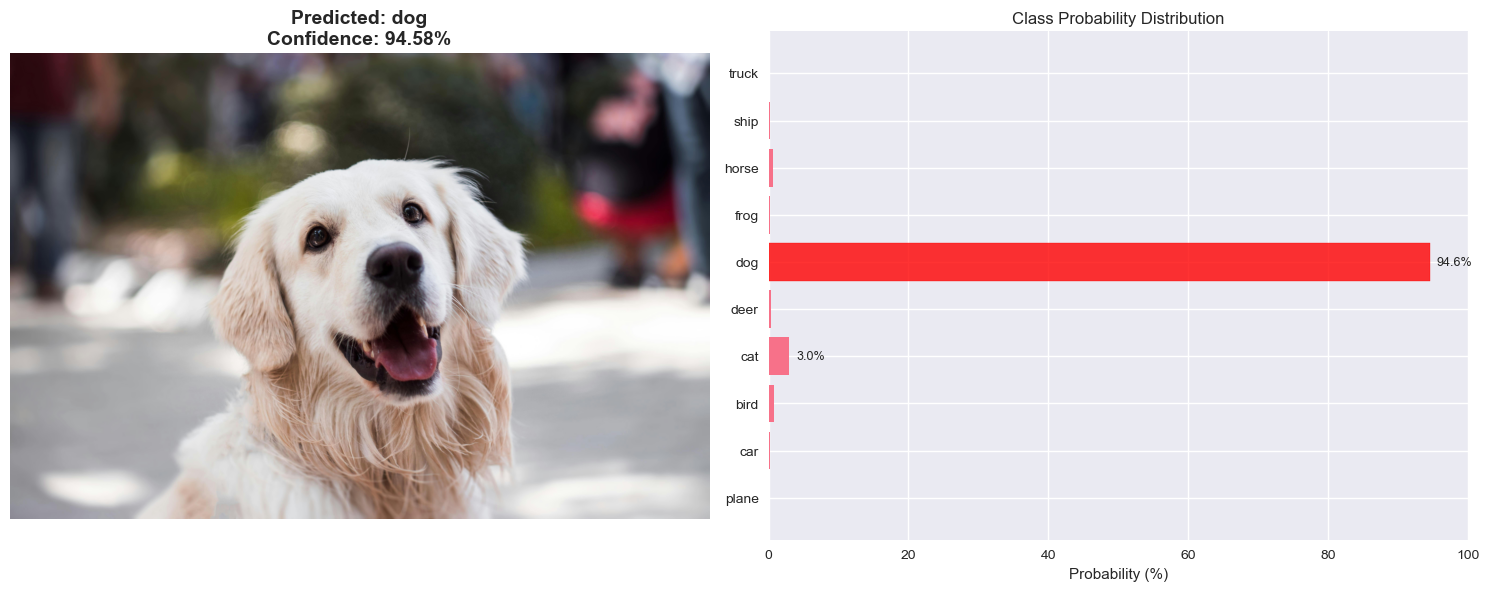

In [4]:
import torch
import torchvision.models as models
from torchvision import transforms
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report
import torch.nn.functional as F

# Setup device
device = 'cuda' if torch.cuda.is_available() else 'cpu'

# Load checkpoint
checkpoint = torch.load('checkpoint_one.pth', map_location=device, weights_only=False)

print("Checkpoint loaded. Keys:", list(checkpoint.keys()))

# Define ResNet18 architecture for CIFAR-10
model = models.resnet18(num_classes=10)  # CIFAR-10 has 10 classes

# Load state_dict
model.load_state_dict(checkpoint['model'])
model = model.to(device)
model.eval()

print("ResNet18 model successfully loaded from checkpoint and ready for use.")

# Print additional info if available
if 'epoch' in checkpoint:
    print(f"Epoch: {checkpoint['epoch']}")

# Transform untuk preprocessing (CIFAR-10)
transform = transforms.Compose([
    transforms.Resize((32, 32)),  # CIFAR-10 size
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465),
                         (0.2023, 0.1994, 0.2010))
])

# Transform untuk visualisasi (tanpa normalisasi)
transform_vis = transforms.Compose([
    transforms.Resize((32, 32)),
    transforms.ToTensor()
])

# Classes CIFAR-10
classes = ['plane','car','bird','cat','deer','dog','frog','horse','ship','truck']

def predict_image(img_path, visualize=True):
    """
    Predict class dari image menggunakan ResNet18 dari checkpoint
    
    Args:
        img_path: path ke image file
        visualize: whether to show visualization
    """
    try:
        # Load dan preprocess image
        image = Image.open(img_path).convert('RGB')
        image_tensor = transform(image).unsqueeze(0).to(device)
        
        # Predict
        with torch.no_grad():
            outputs = model(image_tensor)
            probabilities = torch.softmax(outputs, dim=1)
            confidence, predicted = probabilities.max(1)
        
        # Results
        predicted_class = classes[predicted.item()]
        confidence_score = confidence.item() * 100
        
        print(f"Predicted class: {predicted_class}")
        print(f"Confidence: {confidence_score:.2f}%")
        
        if visualize:
            visualize_prediction(image, probabilities.cpu().numpy()[0], predicted_class, confidence_score)
        
        return predicted_class, confidence_score, probabilities.cpu().numpy()[0]
        
    except Exception as e:
        print(f"Error predicting image: {str(e)}")
        return None, None, None

def visualize_prediction(image, probabilities, predicted_class, confidence_score):
    """
    Visualisasi hasil prediksi dengan gambar dan probability distribution
    """
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))
    
    # Plot gambar
    ax1.imshow(image)
    ax1.set_title(f'Predicted: {predicted_class}\nConfidence: {confidence_score:.2f}%', 
                  fontsize=14, fontweight='bold')
    ax1.axis('off')
    
    # Plot probability distribution
    y_pos = np.arange(len(classes))
    bars = ax2.barh(y_pos, probabilities * 100)
    ax2.set_yticks(y_pos)
    ax2.set_yticklabels(classes)
    ax2.set_xlabel('Probability (%)')
    ax2.set_title('Class Probability Distribution')
    ax2.set_xlim(0, 100)
    
    # Highlight predicted class
    max_idx = np.argmax(probabilities)
    bars[max_idx].set_color('red')
    bars[max_idx].set_alpha(0.8)
    
    # Add probability values on bars
    for i, (bar, prob) in enumerate(zip(bars, probabilities * 100)):
        if prob > 1:  # Only show if probability > 1%
            ax2.text(prob + 1, bar.get_y() + bar.get_height()/2, 
                    f'{prob:.1f}%', va='center', fontsize=9)
    
    plt.tight_layout()
    plt.show()

def plot_training_history(checkpoint):
    """
    Plot training history jika tersedia di checkpoint
    """
    if 'train_losses' in checkpoint and 'train_accuracies' in checkpoint:
        train_losses = checkpoint['train_losses']
        train_accuracies = checkpoint['train_accuracies']
        
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
        
        # Plot training loss
        epochs = range(1, len(train_losses) + 1)
        ax1.plot(epochs, train_losses, 'b-', label='Training Loss', linewidth=2)
        if 'val_losses' in checkpoint:
            ax1.plot(epochs, checkpoint['val_losses'], 'r-', label='Validation Loss', linewidth=2)
            ax1.legend()
        ax1.set_title('Training Loss Over Time')
        ax1.set_xlabel('Epoch')
        ax1.set_ylabel('Loss')
        ax1.grid(True, alpha=0.3)
        
        # Plot training accuracy
        ax2.plot(epochs, train_accuracies, 'g-', label='Training Accuracy', linewidth=2)
        if 'val_accuracies' in checkpoint:
            ax2.plot(epochs, checkpoint['val_accuracies'], 'orange', label='Validation Accuracy', linewidth=2)
            ax2.legend()
        ax2.set_title('Training Accuracy Over Time')
        ax2.set_xlabel('Epoch')
        ax2.set_ylabel('Accuracy (%)')
        ax2.grid(True, alpha=0.3)
        
        plt.tight_layout()
        plt.show()
    else:
        print("Training history not available in checkpoint")

def evaluate_model_on_dataset(dataloader, max_samples=1000):
    """
    Evaluasi model pada dataset dan buat confusion matrix
    """
    model.eval()
    all_predictions = []
    all_labels = []
    all_probabilities = []
    
    with torch.no_grad():
        sample_count = 0
        for images, labels in dataloader:
            if sample_count >= max_samples:
                break
                
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            probabilities = torch.softmax(outputs, dim=1)
            _, predicted = torch.max(outputs, 1)
            
            all_predictions.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
            all_probabilities.extend(probabilities.cpu().numpy())
            
            sample_count += len(images)
    
    # Confusion Matrix
    cm = confusion_matrix(all_labels, all_predictions)
    
    plt.figure(figsize=(12, 10))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                xticklabels=classes, yticklabels=classes)
    plt.title('Confusion Matrix')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.tight_layout()
    plt.show()
    
    # Classification Report
    print("\nClassification Report:")
    print(classification_report(all_labels, all_predictions, target_names=classes))
    
    # Accuracy per class
    plot_class_accuracy(cm)
    
    return all_predictions, all_labels, all_probabilities

def plot_class_accuracy(confusion_matrix):
    """
    Plot accuracy per class dari confusion matrix
    """
    # Calculate accuracy per class
    class_accuracy = []
    for i in range(len(classes)):
        correct = confusion_matrix[i, i]
        total = np.sum(confusion_matrix[i, :])
        accuracy = correct / total if total > 0 else 0
        class_accuracy.append(accuracy * 100)
    
    plt.figure(figsize=(12, 6))
    bars = plt.bar(classes, class_accuracy, color='skyblue', edgecolor='navy', alpha=0.7)
    plt.title('Accuracy per Class')
    plt.xlabel('Classes')
    plt.ylabel('Accuracy (%)')
    plt.xticks(rotation=45)
    plt.ylim(0, 100)
    
    # Add value labels on bars
    for bar, acc in zip(bars, class_accuracy):
        plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 1, 
                f'{acc:.1f}%', ha='center', va='bottom', fontweight='bold')
    
    plt.tight_layout()
    plt.show()

def visualize_model_predictions_grid(image_paths, grid_size=(3, 3)):
    """
    Visualisasi prediksi untuk multiple images dalam grid
    """
    fig, axes = plt.subplots(grid_size[0], grid_size[1], figsize=(15, 15))
    axes = axes.flatten() if grid_size[0] * grid_size[1] > 1 else [axes]
    
    for i, img_path in enumerate(image_paths[:len(axes)]):
        if i >= len(axes):
            break
            
        try:
            # Load image
            image = Image.open(img_path).convert('RGB')
            image_tensor = transform(image).unsqueeze(0).to(device)
            
            # Predict
            with torch.no_grad():
                outputs = model(image_tensor)
                probabilities = torch.softmax(outputs, dim=1)
                confidence, predicted = probabilities.max(1)
            
            predicted_class = classes[predicted.item()]
            confidence_score = confidence.item() * 100
            
            # Plot
            axes[i].imshow(image)
            axes[i].set_title(f'{predicted_class}\n{confidence_score:.1f}%', 
                             fontsize=12, fontweight='bold')
            axes[i].axis('off')
            
        except Exception as e:
            axes[i].text(0.5, 0.5, f'Error: {str(e)}', 
                        transform=axes[i].transAxes, ha='center', va='center')
            axes[i].set_title('Error loading image')
    
    # Hide empty subplots
    for i in range(len(image_paths), len(axes)):
        axes[i].axis('off')
    
    plt.tight_layout()
    plt.show()

def analyze_model_confidence(image_paths):
    """
    Analisis confidence score dari multiple predictions
    """
    confidences = []
    predictions = []
    
    for img_path in image_paths:
        pred_class, conf_score, _ = predict_image(img_path, visualize=False)
        if pred_class:
            confidences.append(conf_score)
            predictions.append(pred_class)
    
    if confidences:
        plt.figure(figsize=(12, 6))
        
        # Histogram of confidence scores
        plt.subplot(1, 2, 1)
        plt.hist(confidences, bins=20, alpha=0.7, color='skyblue', edgecolor='black')
        plt.title('Distribution of Confidence Scores')
        plt.xlabel('Confidence (%)')
        plt.ylabel('Frequency')
        plt.axvline(np.mean(confidences), color='red', linestyle='--', 
                   label=f'Mean: {np.mean(confidences):.1f}%')
        plt.legend()
        
        # Bar plot of predictions
        plt.subplot(1, 2, 2)
        unique_preds, counts = np.unique(predictions, return_counts=True)
        plt.bar(unique_preds, counts, color='lightgreen', edgecolor='black')
        plt.title('Prediction Distribution')
        plt.xlabel('Predicted Classes')
        plt.ylabel('Count')
        plt.xticks(rotation=45)
        
        plt.tight_layout()
        plt.show()
        
        print(f"Average confidence: {np.mean(confidences):.2f}%")
        print(f"Confidence std: {np.std(confidences):.2f}%")

# Main execution
if __name__ == "__main__":
    # Plot training history jika tersedia
    print("\n=== Training History ===")
    plot_training_history(checkpoint)
    
    # Test single prediction dengan visualisasi
    print("\n=== Single Image Prediction ===")
    img_path = "dog.jpg"  # Ganti dengan path image Anda
    print(f"Testing prediction on: {img_path}")
    predict_image(img_path, visualize=True)
    
    # Contoh untuk multiple images (uncomment jika punya multiple images)
    """
    print("\n=== Multiple Images Analysis ===")
    image_paths = ["dog.jpg", "cat.jpg", "plane.jpg"]  # Ganti dengan paths Anda
    
    # Grid visualization
    visualize_model_predictions_grid(image_paths)
    
    # Confidence analysis
    analyze_model_confidence(image_paths)
    """
    
    # Jika punya test dataloader, uncomment untuk evaluasi lengkap
    """
    print("\n=== Model Evaluation on Test Set ===")
    # Contoh: test_loader harus didefinisikan
    # evaluate_model_on_dataset(test_loader, max_samples=1000)
    """

=== Testing Original Prediction ===
Predicted class: dog
Confidence: 94.58%


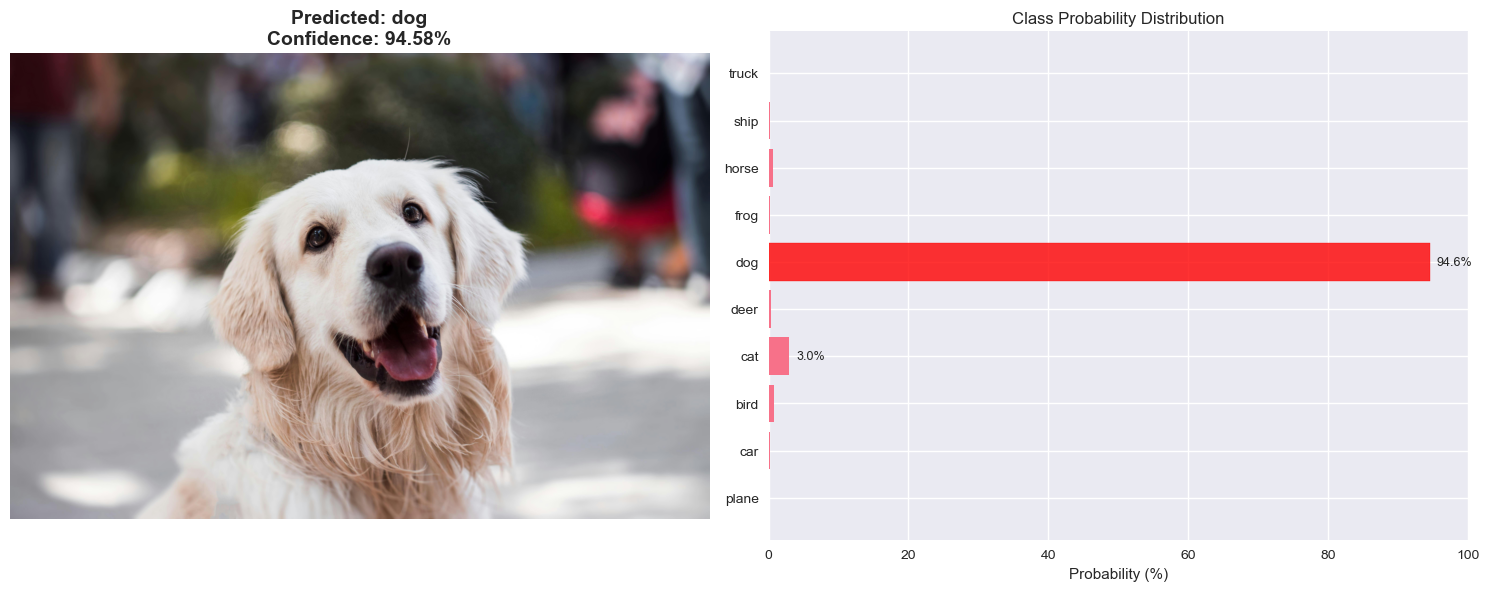


STARTING I-FGSM ATTACK ANALYSIS
Starting Complete I-FGSM Attack Analysis
Target image: dog.jpg
Testing parameters:
   Epsilons: [0.001, 0.005, 0.01, 0.03, 0.05, 0.1]
   Iterations: [5, 10, 20, 40]
   Alpha ratios: [0.1, 0.2, 0.25, 0.5]
Using loaded model: ResNet18 for CIFAR-10
COMPREHENSIVE I-FGSM ATTACK ANALYSIS
Loaded image: dog.jpg
Original prediction: dog (94.6%)
Testing 96 parameter combinations:
   Epsilons: [0.001, 0.005, 0.01, 0.03, 0.05, 0.1]
   Iterations: [5, 10, 20, 40]
   Alpha ratios: [0.1, 0.2, 0.25, 0.5]

--------------------------------------------------------------------------------
Test   1/96 | ε=0.001 | iter= 5 | α=0.0001 ... FAILED | dog → dog | Conf:  +0.1% | PSNR:  66.0dB
Test   2/96 | ε=0.001 | iter= 5 | α=0.0002 ... FAILED | dog → dog | Conf:  +0.2% | PSNR:  60.1dB
Test   3/96 | ε=0.001 | iter= 5 | α=0.0003 ... FAILED | dog → dog | Conf:  +0.2% | PSNR:  60.1dB
Test   4/96 | ε=0.001 | iter= 5 | α=0.0005 ... FAILED | dog → dog | Conf:  +0.2% | PSNR:  60.0dB
Tes

C:\Users\Michael Anggi\AppData\Local\Temp\ipykernel_19452\214831944.py:425: UserWarning: You passed a edgecolor/edgecolors ('black') for an unfilled marker ('x').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  ax3.scatter(failed_df['epsilon'], failed_df['psnr'],


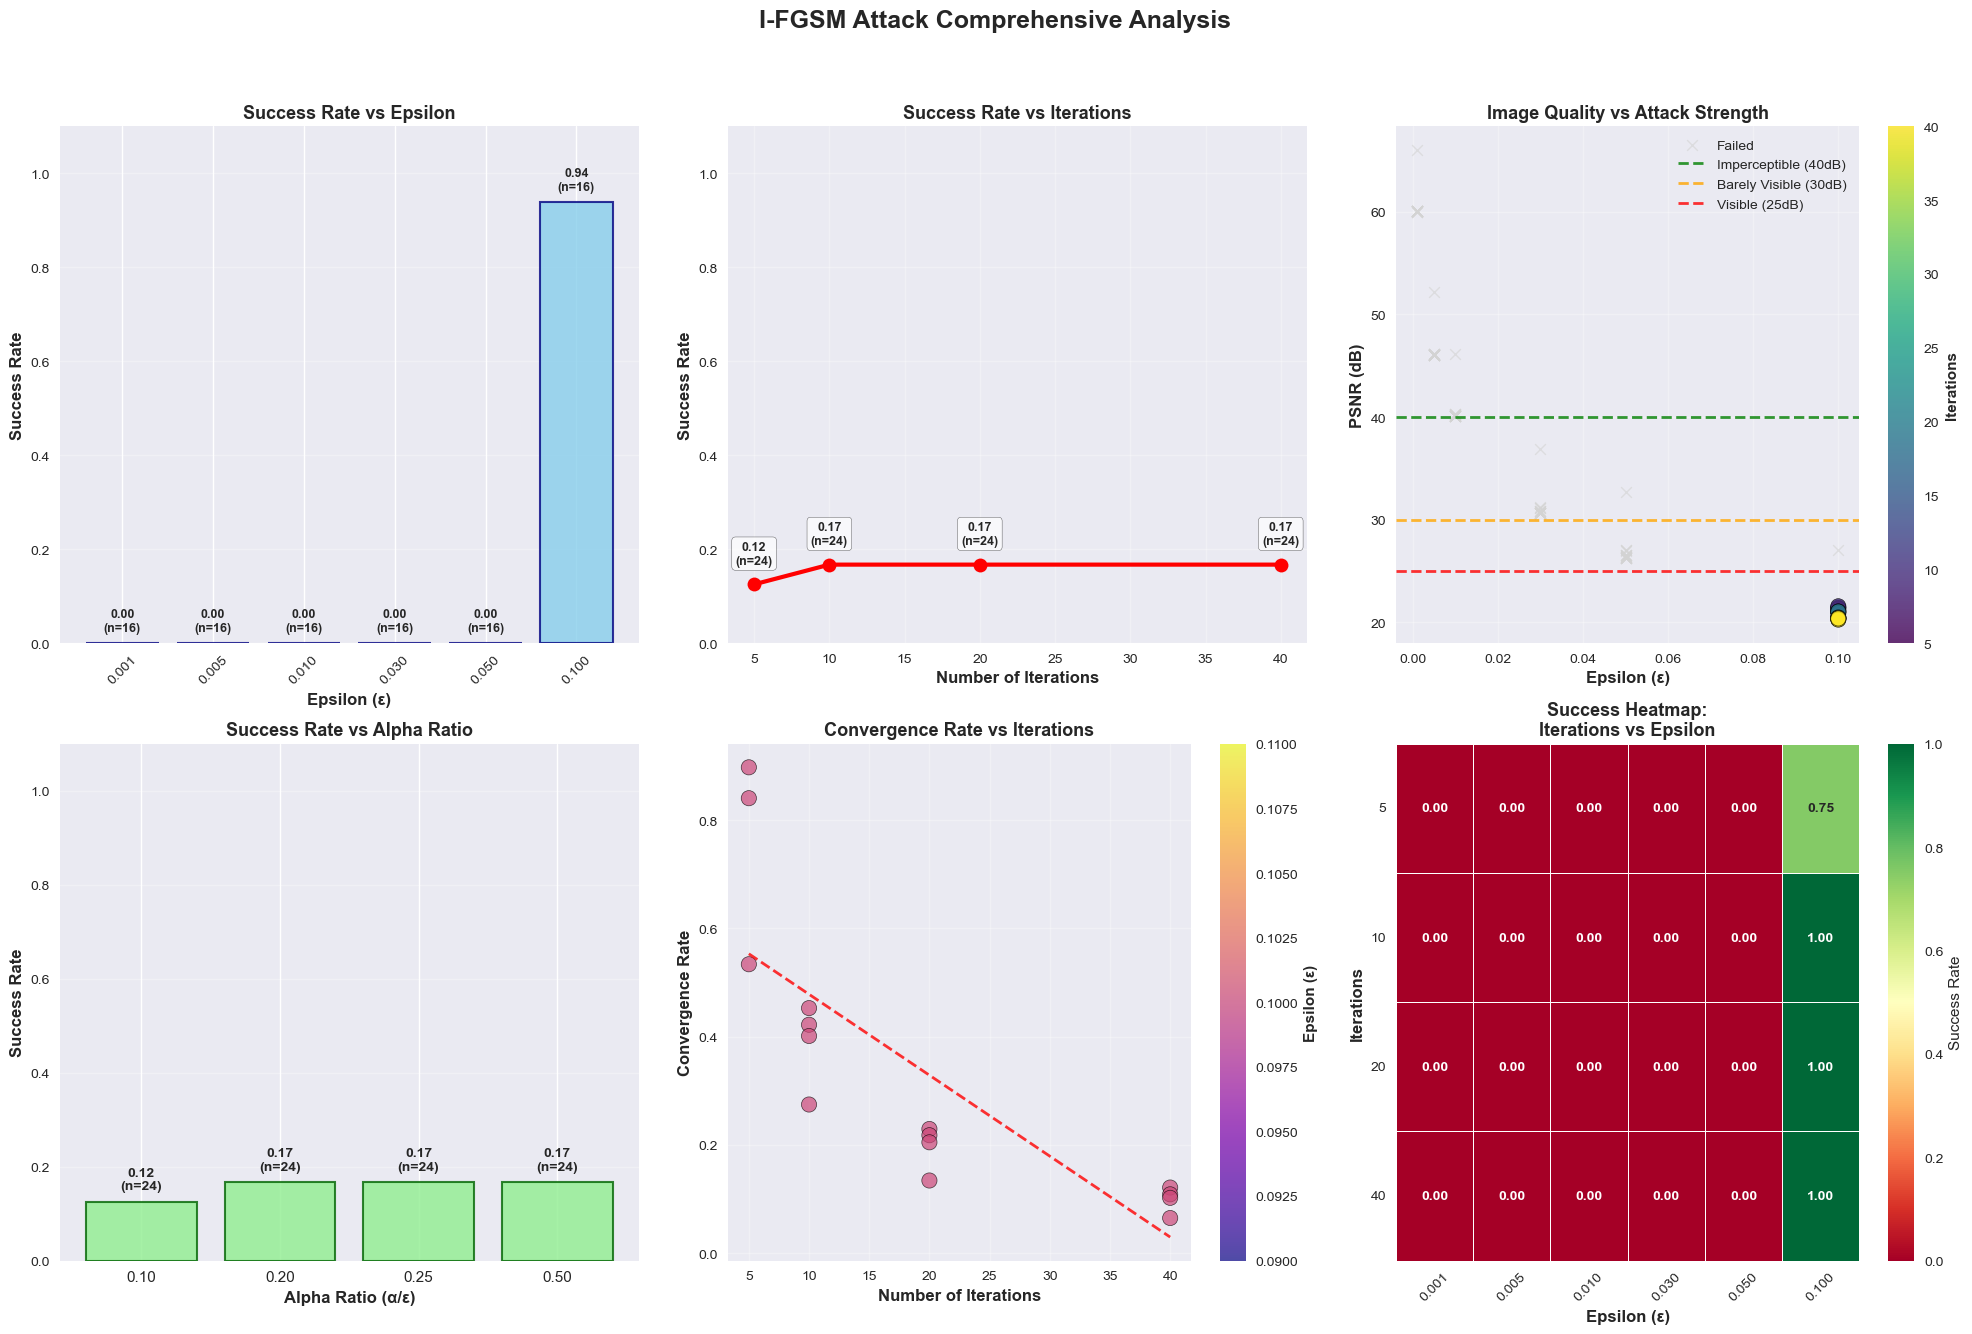


DETAILED ANALYSIS OF TOP ATTACKS

BEST QUALITY (HIGHEST PSNR)
--------------------------------------------------


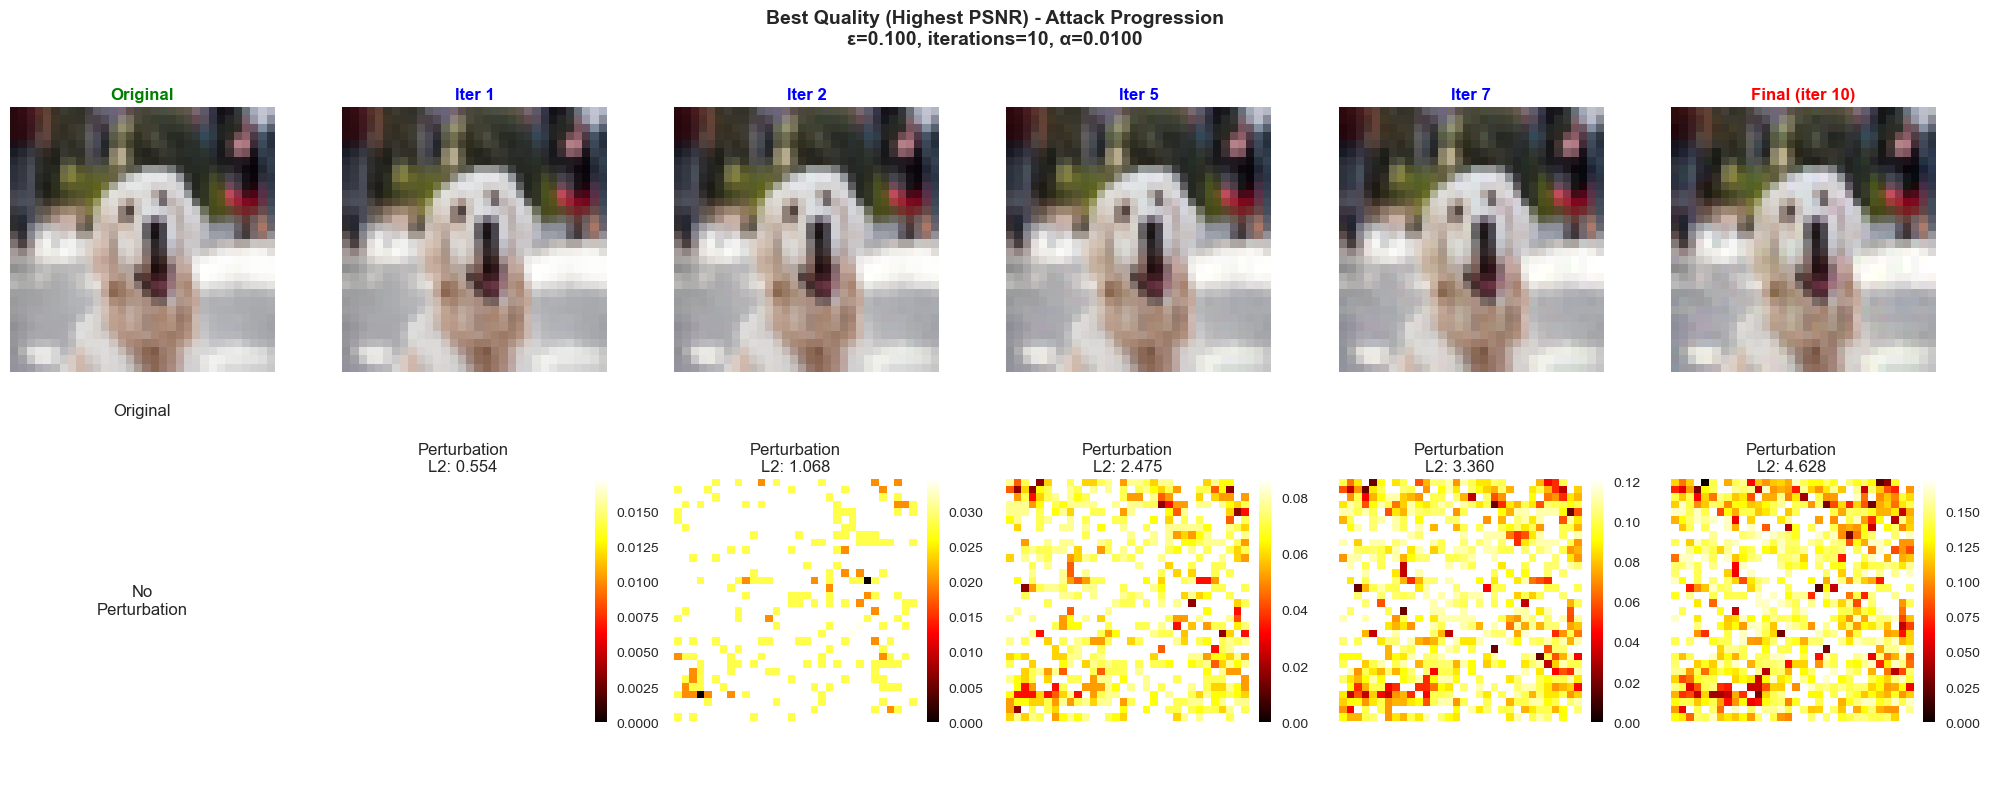

Parameters:
  Epsilon (ε): 0.100
  Iterations: 10
  Alpha: 0.0100 (ratio: 0.10)

Results:
  Original: dog (94.6%)
  Adversarial: horse (24.5%)
  Confidence drop: 70.0%

Quality Metrics:
  PSNR: 21.57 dB (Clearly Visible)
  MSE: 0.006973
  L2 distance: 4.6283
  L∞ distance: 0.1000

Convergence:
  Convergence rate: 0.452670
  Avg gradient magnitude: 0.3652

MOST EFFICIENT (SMALLEST Ε)
--------------------------------------------------


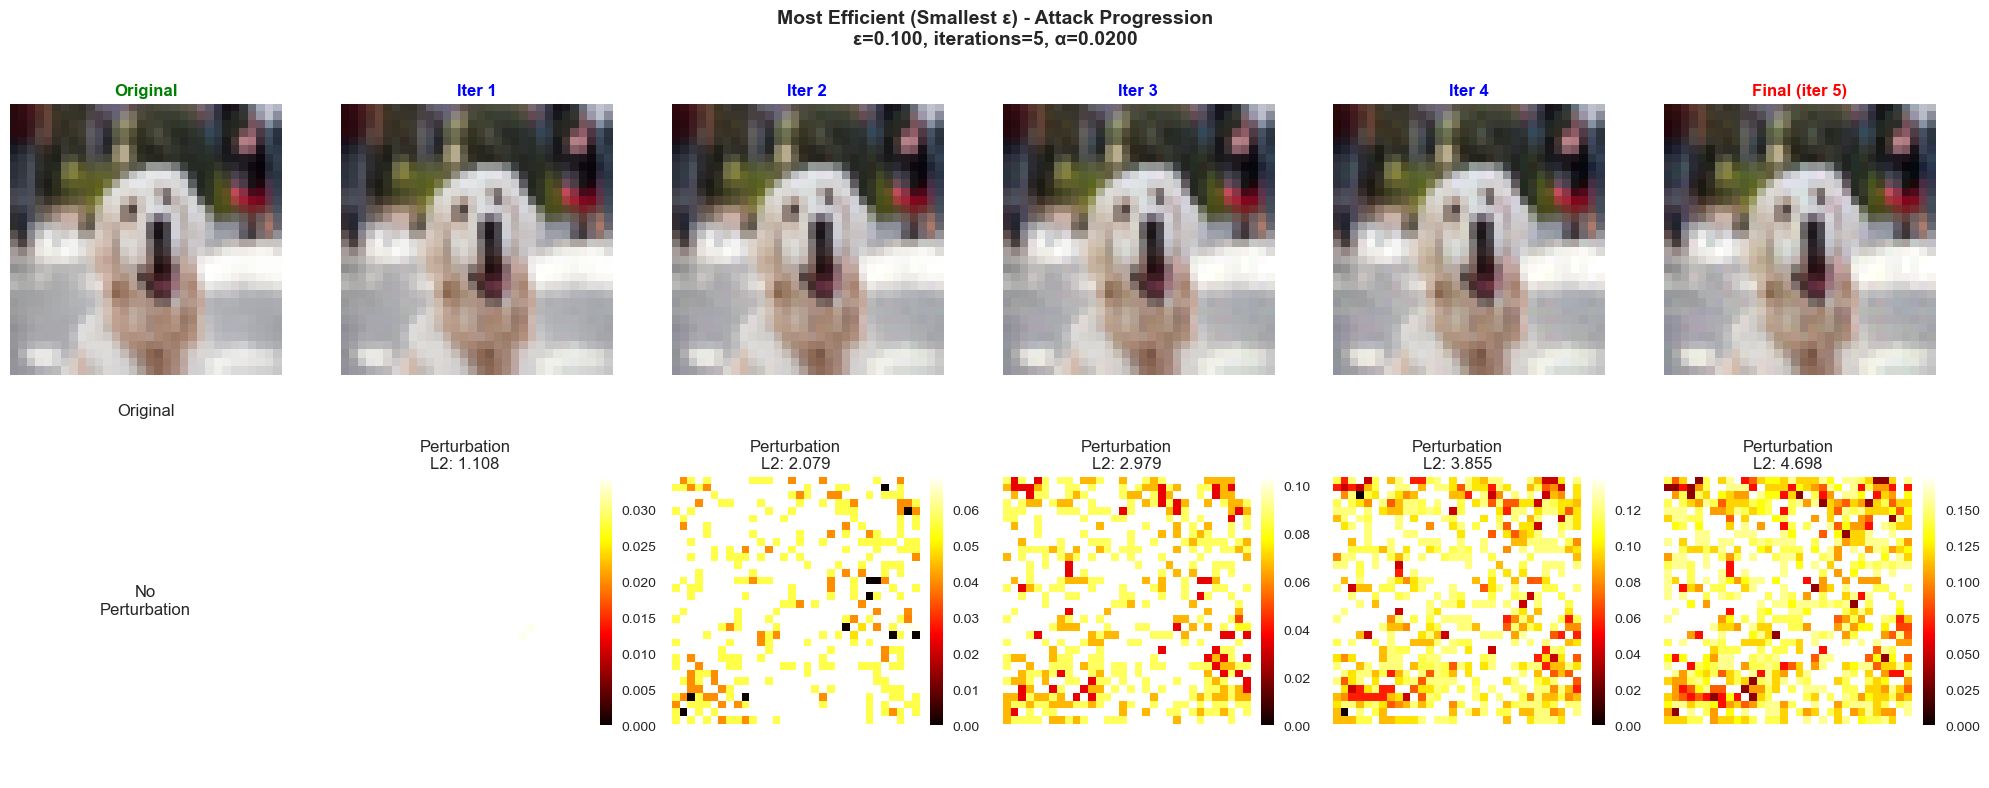

Parameters:
  Epsilon (ε): 0.100
  Iterations: 5
  Alpha: 0.0200 (ratio: 0.20)

Results:
  Original: dog (94.6%)
  Adversarial: horse (25.0%)
  Confidence drop: 69.6%

Quality Metrics:
  PSNR: 21.44 dB (Clearly Visible)
  MSE: 0.007184
  L2 distance: 4.6979
  L∞ distance: 0.1000

Convergence:
  Convergence rate: 0.897361
  Avg gradient magnitude: 0.3007

STRONGEST EFFECT (LARGEST CONFIDENCE DROP)
--------------------------------------------------


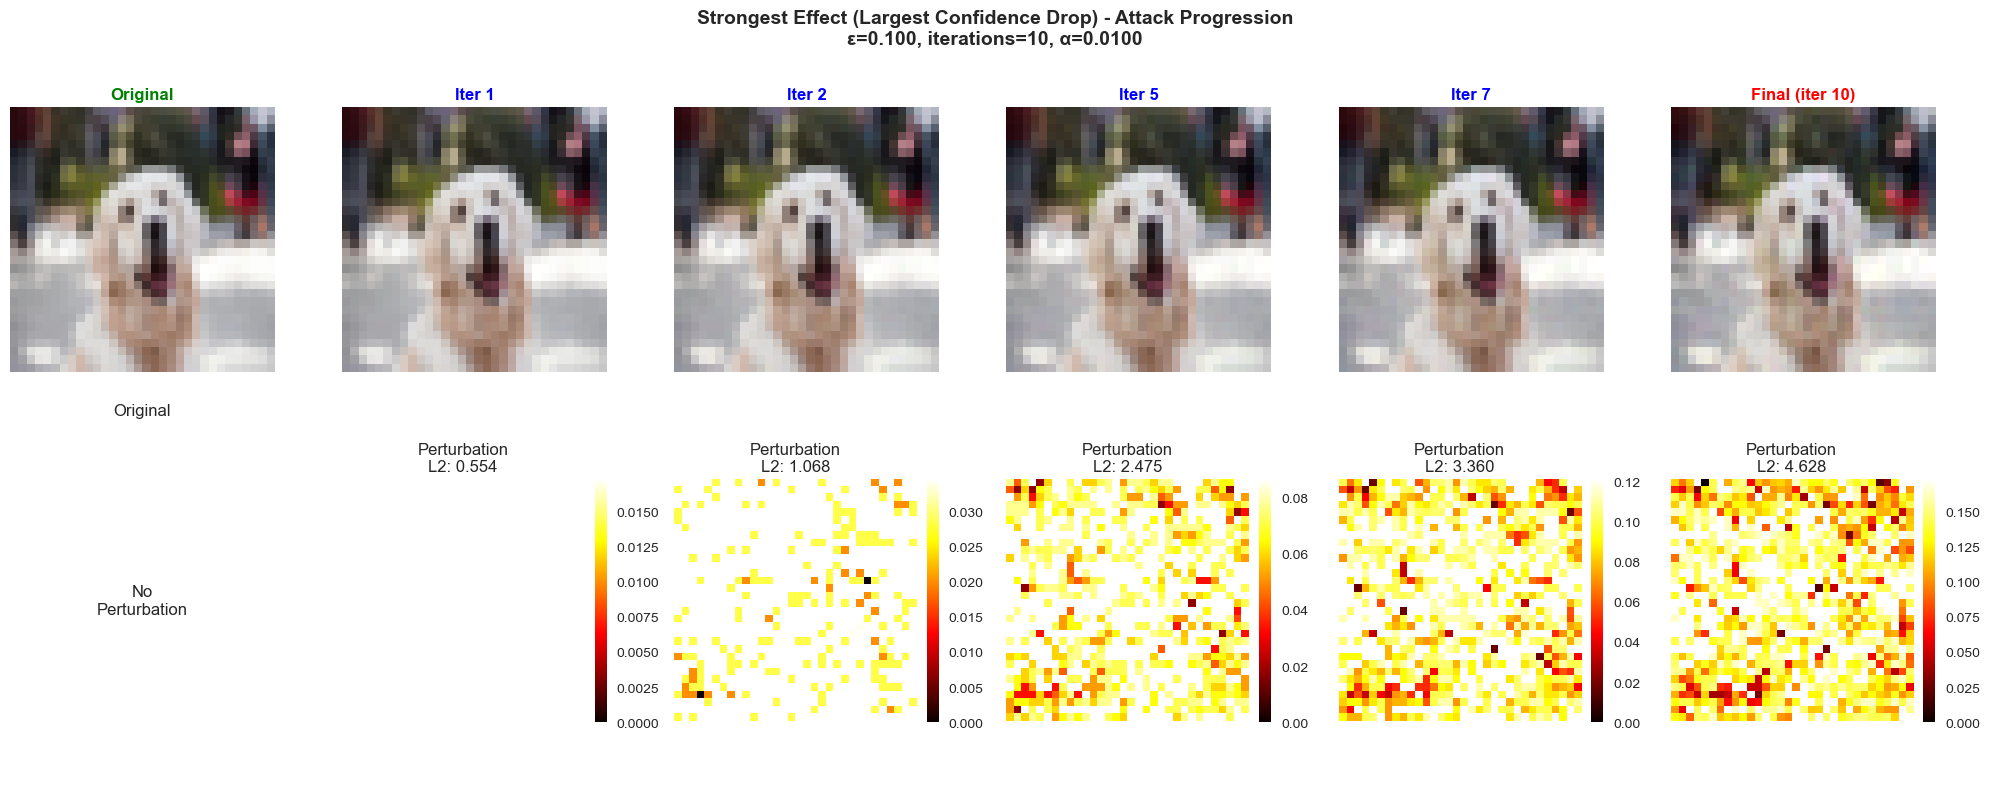

Parameters:
  Epsilon (ε): 0.100
  Iterations: 10
  Alpha: 0.0100 (ratio: 0.10)

Results:
  Original: dog (94.6%)
  Adversarial: horse (24.5%)
  Confidence drop: 70.0%

Quality Metrics:
  PSNR: 21.57 dB (Clearly Visible)
  MSE: 0.006973
  L2 distance: 4.6283
  L∞ distance: 0.1000

Convergence:
  Convergence rate: 0.452670
  Avg gradient magnitude: 0.3652

I-FGSM Analysis completed successfully!
Results saved to DataFrame with 96 test cases
Found 15 successful attack configurations

SUCCESS! I-FGSM Analysis completed with 96 test results.

ANALYSIS COMPLETE!
Key insights:
• I-FGSM provides better control over attack parameters
• Iterative approach often yields higher quality adversarial examples
• Multiple iterations allow for more precise perturbations
• Parameter tuning (ε, iterations, α) enables attack customization


In [6]:
# Integrated I-FGSM (Iterative Fast Gradient Sign Method) Attack Analysis
# This code works with your existing model loading from the previous cells

import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns
from PIL import Image
import time

# Set style untuk plots yang lebih bagus
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")

def inverse_transform(tensor):
    """
    Inverse of CIFAR-10 normalization for visualization
    """
    mean = torch.tensor([0.4914, 0.4822, 0.4465]).view(3, 1, 1)
    std = torch.tensor([0.2023, 0.1994, 0.2010]).view(3, 1, 1)
    return tensor * std + mean

def ifgsm_attack(image, epsilon, alpha, num_iterations, data_grad=None):
    """
    I-FGSM (Iterative FGSM) Attack implementation
    
    Args:
        image: Input image tensor
        epsilon: Maximum perturbation bound (L-infinity)
        alpha: Step size per iteration (typically epsilon/num_iterations)
        num_iterations: Number of iterations
        data_grad: Initial gradient (optional, will compute if None)
    
    Returns:
        Perturbed image, list of intermediate images, list of gradients
    """
    # Initialize
    perturbed_image = image.clone().detach()
    perturbed_image.requires_grad = True
    
    # Store intermediate results
    intermediate_images = [perturbed_image.clone().detach()]
    gradients_history = []
    
    # Get original prediction for targeted loss
    with torch.no_grad():
        original_output = model(image)
        original_pred = torch.argmax(original_output, dim=1)
    
    # CIFAR-10 normalization bounds
    mean = torch.tensor([0.4914, 0.4822, 0.4465]).view(1, 3, 1, 1).to(device)
    std = torch.tensor([0.2023, 0.1994, 0.2010]).view(1, 3, 1, 1).to(device)
    min_val = (0 - mean) / std
    max_val = (1 - mean) / std
    
    for i in range(num_iterations):
        # Zero gradients
        if perturbed_image.grad is not None:
            perturbed_image.grad.zero_()
        
        # Forward pass
        output = model(perturbed_image)
        loss = F.cross_entropy(output, original_pred)
        
        # Backward pass
        loss.backward()
        data_grad = perturbed_image.grad.data
        gradients_history.append(data_grad.clone().detach())
        
        # Apply FGSM step
        sign_data_grad = data_grad.sign()
        perturbed_image = perturbed_image.detach() + alpha * sign_data_grad
        
        # Project back to epsilon ball
        perturbation = perturbed_image - image
        perturbation = torch.clamp(perturbation, -epsilon, epsilon)
        perturbed_image = image + perturbation
        
        # Clamp to valid pixel range
        perturbed_image = torch.clamp(perturbed_image, min_val, max_val)
        perturbed_image.requires_grad = True
        
        # Store intermediate result
        intermediate_images.append(perturbed_image.clone().detach())
    
    return perturbed_image.detach(), intermediate_images, gradients_history

def calculate_metrics(original, adversarial):
    """
    Calculate various distance metrics between original and adversarial images
    """
    diff = original - adversarial
    
    # Mean Squared Error
    mse = torch.mean(diff ** 2).item()
    
    # Peak Signal-to-Noise Ratio
    psnr = 20 * np.log10(1.0 / np.sqrt(mse)) if mse > 0 else float('inf')
    
    # L2 (Euclidean) distance
    l2_distance = torch.norm(diff).item()
    
    # L-infinity (maximum) distance
    linf_distance = torch.max(torch.abs(diff)).item()
    
    return {
        'mse': mse,
        'psnr': psnr,
        'l2_distance': l2_distance,
        'linf_distance': linf_distance
    }

def classify_perceptibility(psnr, mse):
    """
    Classify perceptibility level based on PSNR
    """
    if psnr > 40:
        return "Imperceptible"
    elif psnr > 30:
        return "Barely Visible"
    elif psnr > 25:
        return "Visible"
    else:
        return "Clearly Visible"

def comprehensive_ifgsm_analysis(img_path, 
                                epsilons=[0.001, 0.005, 0.01, 0.03, 0.05, 0.1],
                                iterations_list=[5, 10, 20, 40],
                                alpha_ratios=[0.1, 0.2, 0.25, 0.5]):
    """
    Comprehensive I-FGSM attack analysis across multiple parameters
    """
    print("="*80)
    print("COMPREHENSIVE I-FGSM ATTACK ANALYSIS")
    print("="*80)
    
    # Load and preprocess image
    try:
        image = Image.open(img_path).convert('RGB')
        print(f"Loaded image: {img_path}")
    except Exception as e:
        print(f"Error loading image: {e}")
        return None
    
    # Store results
    results_data = []
    original_image = None
    best_attacks = {}
    
    # Get original prediction
    model.eval()
    image_tensor = transform(image).unsqueeze(0).to(device)
    
    with torch.no_grad():
        original_output = model(image_tensor)
        original_probs = F.softmax(original_output, dim=1)
        original_confidence, original_pred = original_probs.max(1)
    
    original_class = classes[original_pred.item()]
    print(f"Original prediction: {original_class} ({original_confidence.item()*100:.1f}%)")
    
    total_tests = len(epsilons) * len(iterations_list) * len(alpha_ratios)
    current_test = 0
    
    print(f"Testing {total_tests} parameter combinations:")
    print(f"   Epsilons: {epsilons}")
    print(f"   Iterations: {iterations_list}")
    print(f"   Alpha ratios: {alpha_ratios}")
    print("\n" + "-"*80)
    
    start_time = time.time()
    
    for eps in epsilons:
        for num_iter in iterations_list:
            for alpha_ratio in alpha_ratios:
                current_test += 1
                alpha = eps * alpha_ratio  # Step size as fraction of epsilon
                
                print(f"Test {current_test:3d}/{total_tests} | ε={eps:5.3f} | iter={num_iter:2d} | α={alpha:.4f}", end=" ... ")
                
                try:
                    # Prepare image with gradient tracking
                    image_tensor = transform(image).unsqueeze(0).to(device)
                    
                    if original_image is None:
                        original_image = image_tensor.detach().clone()
                    
                    # Generate adversarial example using I-FGSM
                    perturbed_data, intermediate_images, gradients_history = ifgsm_attack(
                        image_tensor, eps, alpha, num_iter
                    )
                    
                    # Predict on adversarial image
                    with torch.no_grad():
                        adv_output = model(perturbed_data)
                        adv_probs = F.softmax(adv_output, dim=1)
                        adv_confidence, adv_pred = adv_probs.max(1)
                    
                    # Calculate results
                    adv_class = classes[adv_pred.item()]
                    success = (original_pred.item() != adv_pred.item())
                    confidence_drop = (original_confidence.item() - adv_confidence.item()) * 100
                    
                    # Calculate metrics
                    metrics = calculate_metrics(original_image, perturbed_data)
                    perceptibility = classify_perceptibility(metrics['psnr'], metrics['mse'])
                    
                    # Calculate convergence metrics
                    convergence_rate = calculate_convergence_rate(intermediate_images, original_image)
                    gradient_magnitude = torch.mean(torch.stack([torch.norm(g) for g in gradients_history])).item()
                    
                    # Store results
                    result = {
                        'epsilon': eps,
                        'iterations': num_iter,
                        'alpha': alpha,
                        'alpha_ratio': alpha_ratio,
                        'success': success,
                        'original_class': original_class,
                        'adversarial_class': adv_class,
                        'original_confidence': original_confidence.item() * 100,
                        'adversarial_confidence': adv_confidence.item() * 100,
                        'confidence_drop': confidence_drop,
                        'perceptibility': perceptibility,
                        'convergence_rate': convergence_rate,
                        'avg_gradient_magnitude': gradient_magnitude,
                        'original_probs': original_probs.cpu().numpy()[0],
                        'adv_probs': adv_probs.cpu().numpy()[0],
                        **metrics
                    }
                    
                    results_data.append(result)
                    
                    # Store best attack for each epsilon
                    if success:
                        key = f"eps_{eps}_iter_{num_iter}_alpha_{alpha_ratio}"
                        best_attacks[key] = {
                            'params': result,
                            'adversarial_image': perturbed_data.clone(),
                            'intermediate_images': intermediate_images,
                            'gradients_history': gradients_history
                        }
                    
                    # Print result
                    status = "SUCCESS" if success else "FAILED"
                    print(f"{status} | {original_class} → {adv_class} | "
                          f"Conf: {confidence_drop:+5.1f}% | PSNR: {metrics['psnr']:5.1f}dB")
                    
                except Exception as e:
                    print(f"ERROR: {str(e)}")
                    continue
    
    elapsed_time = time.time() - start_time
    print("-"*80)
    print(f"Total analysis time: {elapsed_time:.1f} seconds")
    
    if not results_data:
        print("No results obtained!")
        return None
    
    # Convert to DataFrame
    df = pd.DataFrame(results_data)
    
    # Print comprehensive summary
    print_ifgsm_summary(df)
    
    # Create visualizations
    create_ifgsm_plots(df, original_image, best_attacks)
    
    # Find and analyze best attacks
    analyze_best_attacks(df, best_attacks, original_image)
    
    return df, best_attacks

def calculate_convergence_rate(intermediate_images, original_image):
    """
    Calculate how quickly the attack converges
    """
    if len(intermediate_images) < 2:
        return 0.0
    
    distances = []
    for img in intermediate_images[1:]:
        distance = torch.norm(img - original_image).item()
        distances.append(distance)
    
    # Calculate rate of change in distance
    if len(distances) > 1:
        rate = np.mean(np.diff(distances))
        return rate
    return 0.0

def print_ifgsm_summary(df):
    """
    Print comprehensive summary of I-FGSM results
    """
    print("\nI-FGSM ANALYSIS SUMMARY")
    print("="*100)
    
    total_tests = len(df)
    successful = df['success'].sum()
    success_rate = successful / total_tests * 100
    
    print(f"Total parameter combinations tested: {total_tests}")
    print(f"Successful attacks: {successful}")
    print(f"Overall success rate: {success_rate:.1f}%")
    
    if successful > 0:
        successful_df = df[df['success'] == True]
        
        print(f"\nBEST ATTACK STATISTICS:")
        
        # Find best attack (highest PSNR among successful)
        best_attack = successful_df.loc[successful_df['psnr'].idxmax()]
        print(f"Best quality attack:")
        print(f"  ε={best_attack['epsilon']:.3f}, iterations={best_attack['iterations']}, "
              f"α={best_attack['alpha']:.4f}")
        print(f"  PSNR: {best_attack['psnr']:.1f} dB ({best_attack['perceptibility']})")
        print(f"  Confidence drop: {best_attack['confidence_drop']:.1f}%")
        
        # Find most efficient attack (smallest epsilon)
        min_eps_attack = successful_df.loc[successful_df['epsilon'].idxmin()]
        print(f"\nMost efficient attack:")
        print(f"  ε={min_eps_attack['epsilon']:.3f}, iterations={min_eps_attack['iterations']}, "
              f"α={min_eps_attack['alpha']:.4f}")
        print(f"  PSNR: {min_eps_attack['psnr']:.1f} dB")
        print(f"  Confidence drop: {min_eps_attack['confidence_drop']:.1f}%")
        
        # Parameter effectiveness analysis
        print(f"\nPARAMETER EFFECTIVENESS:")
        
        # Best epsilon values
        eps_success = successful_df.groupby('epsilon')['success'].count().sort_values(ascending=False)
        print(f"Most effective epsilon values: {list(eps_success.head(3).index)}")
        
        # Best iteration counts
        iter_success = successful_df.groupby('iterations')['success'].count().sort_values(ascending=False)
        print(f"Most effective iteration counts: {list(iter_success.head(3).index)}")
        
        # Best alpha ratios
        alpha_success = successful_df.groupby('alpha_ratio')['success'].count().sort_values(ascending=False)
        print(f"Most effective alpha ratios: {list(alpha_success.head(3).index)}")
        
        # Quality distribution
        print(f"\nPERCEPTIBILITY BREAKDOWN:")
        perceptibility_counts = successful_df['perceptibility'].value_counts()
        for level, count in perceptibility_counts.items():
            percentage = count / len(successful_df) * 100
            print(f"  {level}: {count} attacks ({percentage:.1f}%)")
        
        # Convergence analysis
        avg_convergence = successful_df['convergence_rate'].mean()
        print(f"\nCONVERGENCE ANALYSIS:")
        print(f"Average convergence rate: {avg_convergence:.6f}")
        
        fast_converging = successful_df[successful_df['convergence_rate'] > avg_convergence]
        if len(fast_converging) > 0:
            print(f"Fast converging attacks: {len(fast_converging)} ({len(fast_converging)/len(successful_df)*100:.1f}%)")

def create_ifgsm_plots(df, original_image, best_attacks):
    """
    Create comprehensive I-FGSM visualization plots with improved clarity
    """
    fig, axes = plt.subplots(2, 3, figsize=(20, 14))
    fig.suptitle('I-FGSM Attack Comprehensive Analysis', fontsize=18, fontweight='bold', y=0.98)
    
    # 1. Success Rate by Epsilon - Improved with better labels
    ax1 = axes[0, 0]
    eps_success = df.groupby('epsilon').agg({'success': ['mean', 'count']}).round(3)
    eps_success.columns = ['success_rate', 'count']
    
    bars1 = ax1.bar(range(len(eps_success)), eps_success['success_rate'], 
                    alpha=0.8, color='skyblue', edgecolor='navy', linewidth=1.5)
    ax1.set_xlabel('Epsilon (ε)', fontsize=12, fontweight='bold')
    ax1.set_ylabel('Success Rate', fontsize=12, fontweight='bold')
    ax1.set_title('Success Rate vs Epsilon', fontsize=13, fontweight='bold')
    ax1.set_ylim(0, 1.1)
    ax1.set_xticks(range(len(eps_success)))
    ax1.set_xticklabels([f'{eps:.3f}' for eps in eps_success.index], rotation=45, fontsize=10)
    ax1.grid(True, alpha=0.3, axis='y')
    
    # Add value labels on bars
    for i, (bar, rate, count) in enumerate(zip(bars1, eps_success['success_rate'], eps_success['count'])):
        height = bar.get_height()
        ax1.text(bar.get_x() + bar.get_width()/2., height + 0.02, 
                f'{rate:.2f}\n(n={count})', ha='center', va='bottom', 
                fontweight='bold', fontsize=9)
    
    # 2. Success Rate by Iterations - Improved with data points
    ax2 = axes[0, 1]
    iter_success = df.groupby('iterations').agg({'success': ['mean', 'count']}).round(3)
    iter_success.columns = ['success_rate', 'count']
    
    ax2.plot(iter_success.index, iter_success['success_rate'], 'ro-', 
             linewidth=3, markersize=10, markerfacecolor='red', markeredgecolor='darkred')
    ax2.set_xlabel('Number of Iterations', fontsize=12, fontweight='bold')
    ax2.set_ylabel('Success Rate', fontsize=12, fontweight='bold')
    ax2.set_title('Success Rate vs Iterations', fontsize=13, fontweight='bold')
    ax2.grid(True, alpha=0.3)
    ax2.set_ylim(0, 1.1)
    
    # Add data point labels
    for iter_count, rate, count in zip(iter_success.index, iter_success['success_rate'], iter_success['count']):
        ax2.annotate(f'{rate:.2f}\n(n={count})', (iter_count, rate), 
                    xytext=(0, 15), textcoords='offset points', ha='center',
                    fontweight='bold', fontsize=9,
                    bbox=dict(boxstyle='round,pad=0.3', facecolor='white', alpha=0.7))
    
    # 3. PSNR vs Epsilon - Much clearer scatter plot
    ax3 = axes[0, 2]
    successful_df = df[df['success'] == True]
    failed_df = df[df['success'] == False]
    
    if len(successful_df) > 0:
        scatter1 = ax3.scatter(successful_df['epsilon'], successful_df['psnr'], 
                              c=successful_df['iterations'], s=120, alpha=0.8, 
                              cmap='viridis', edgecolors='black', linewidth=0.5)
        cbar = plt.colorbar(scatter1, ax=ax3)
        cbar.set_label('Iterations', fontsize=11, fontweight='bold')
        cbar.ax.tick_params(labelsize=10)
    
    if len(failed_df) > 0:
        ax3.scatter(failed_df['epsilon'], failed_df['psnr'], 
                   c='lightgray', s=60, alpha=0.6, marker='x', 
                   edgecolors='black', linewidth=1, label='Failed')
    
    ax3.axhline(y=40, color='green', linestyle='--', linewidth=2, alpha=0.8, label='Imperceptible (40dB)')
    ax3.axhline(y=30, color='orange', linestyle='--', linewidth=2, alpha=0.8, label='Barely Visible (30dB)')
    ax3.axhline(y=25, color='red', linestyle='--', linewidth=2, alpha=0.8, label='Visible (25dB)')
    ax3.set_xlabel('Epsilon (ε)', fontsize=12, fontweight='bold')
    ax3.set_ylabel('PSNR (dB)', fontsize=12, fontweight='bold')
    ax3.set_title('Image Quality vs Attack Strength', fontsize=13, fontweight='bold')
    ax3.legend(fontsize=10, loc='upper right')
    ax3.grid(True, alpha=0.3)
    
    # 4. Alpha Ratio Effectiveness - Better bar chart
    ax4 = axes[1, 0]
    alpha_success = df.groupby('alpha_ratio').agg({'success': ['mean', 'count']}).round(3)
    alpha_success.columns = ['success_rate', 'count']
    
    bars4 = ax4.bar(range(len(alpha_success)), alpha_success['success_rate'], 
                    alpha=0.8, color='lightgreen', edgecolor='darkgreen', linewidth=1.5)
    ax4.set_xlabel('Alpha Ratio (α/ε)', fontsize=12, fontweight='bold')
    ax4.set_ylabel('Success Rate', fontsize=12, fontweight='bold')
    ax4.set_title('Success Rate vs Alpha Ratio', fontsize=13, fontweight='bold')
    ax4.set_ylim(0, 1.1)
    ax4.set_xticks(range(len(alpha_success)))
    ax4.set_xticklabels([f'{ratio:.2f}' for ratio in alpha_success.index], fontsize=11)
    ax4.grid(True, alpha=0.3, axis='y')
    
    # Add comprehensive labels on bars
    for i, (bar, rate, count) in enumerate(zip(bars4, alpha_success['success_rate'], alpha_success['count'])):
        height = bar.get_height()
        ax4.text(bar.get_x() + bar.get_width()/2., height + 0.02,
                f'{rate:.2f}\n(n={count})', ha='center', va='bottom', 
                fontweight='bold', fontsize=10)
    
    # 5. Convergence Analysis - Enhanced scatter with trend
    ax5 = axes[1, 1]
    if len(successful_df) > 0:
        scatter5 = ax5.scatter(successful_df['iterations'], successful_df['convergence_rate'], 
                              s=120, alpha=0.7, c=successful_df['epsilon'], 
                              cmap='plasma', edgecolors='black', linewidth=0.5)
        cbar5 = plt.colorbar(scatter5, ax=ax5)
        cbar5.set_label('Epsilon (ε)', fontsize=11, fontweight='bold')
        cbar5.ax.tick_params(labelsize=10)
        
        # Add trend line
        z = np.polyfit(successful_df['iterations'], successful_df['convergence_rate'], 1)
        p = np.poly1d(z)
        ax5.plot(successful_df['iterations'].unique(), 
                p(successful_df['iterations'].unique()), "r--", alpha=0.8, linewidth=2)
        
    ax5.set_xlabel('Number of Iterations', fontsize=12, fontweight='bold')
    ax5.set_ylabel('Convergence Rate', fontsize=12, fontweight='bold')
    ax5.set_title('Convergence Rate vs Iterations', fontsize=13, fontweight='bold')
    ax5.grid(True, alpha=0.3)
    
    # 6. Detailed Success Heatmap - Much clearer
    ax6 = axes[1, 2]
    if len(successful_df) > 0:
        # Create more detailed heatmap
        pivot_data = df.pivot_table(
            values='success', 
            index='iterations', 
            columns='epsilon', 
            aggfunc='mean',
            fill_value=0
        )
        
        sns.heatmap(pivot_data, annot=True, fmt='.2f', cmap='RdYlGn', ax=ax6, 
                   cbar_kws={'label': 'Success Rate'}, 
                   annot_kws={'fontsize': 10, 'fontweight': 'bold'},
                   linewidths=0.5, linecolor='white')
        ax6.set_title('Success Heatmap:\nIterations vs Epsilon', fontsize=13, fontweight='bold')
        ax6.set_xlabel('Epsilon (ε)', fontsize=12, fontweight='bold')
        ax6.set_ylabel('Iterations', fontsize=12, fontweight='bold')
        
        # Rotate x-axis labels for better readability
        ax6.set_xticklabels([f'{float(label.get_text()):.3f}' for label in ax6.get_xticklabels()], 
                           rotation=45, fontsize=10)
        ax6.set_yticklabels(ax6.get_yticklabels(), rotation=0, fontsize=10)
    else:
        ax6.text(0.5, 0.5, 'No Successful\nAttacks Found', 
                ha='center', va='center', transform=ax6.transAxes, 
                fontsize=16, fontweight='bold', color='red')
        ax6.set_title('Success Heatmap: No Data', fontsize=13, fontweight='bold')
    
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()

def analyze_best_attacks(df, best_attacks, original_image):
    """
    Detailed analysis of the best performing attacks
    """
    successful_df = df[df['success'] == True]
    if len(successful_df) == 0:
        print("No successful attacks to analyze")
        return
    
    # Find different types of "best" attacks
    best_quality = successful_df.loc[successful_df['psnr'].idxmax()]
    best_efficiency = successful_df.loc[successful_df['epsilon'].idxmin()]
    best_confidence_drop = successful_df.loc[successful_df['confidence_drop'].idxmax()]
    
    print(f"\nDETAILED ANALYSIS OF TOP ATTACKS")
    print("="*80)
    
    # Analyze each type of best attack
    attacks_to_analyze = [
        ("Best Quality (Highest PSNR)", best_quality),
        ("Most Efficient (Smallest ε)", best_efficiency),
        ("Strongest Effect (Largest Confidence Drop)", best_confidence_drop)
    ]
    
    for attack_name, attack_data in attacks_to_analyze:
        print(f"\n{attack_name.upper()}")
        print("-" * 50)
        
        # Find corresponding attack data
        key = f"eps_{attack_data['epsilon']}_iter_{attack_data['iterations']}_alpha_{attack_data['alpha_ratio']}"
        if key in best_attacks:
            attack_info = best_attacks[key]
            visualize_attack_progression(attack_name, attack_info, original_image)
            print_attack_details(attack_data)
        else:
            print(f"Attack data not found for {attack_name}")

def visualize_attack_progression(attack_name, attack_info, original_image):
    """
    Visualize how the attack progresses through iterations
    """
    intermediate_images = attack_info['intermediate_images']
    params = attack_info['params']
    
    # Select key iterations to show
    num_iterations = len(intermediate_images) - 1
    if num_iterations <= 6:
        show_iterations = list(range(0, len(intermediate_images)))
    else:
        # Show: original, early, middle, late, final
        show_iterations = [0, 1, num_iterations//4, num_iterations//2, 
                          3*num_iterations//4, num_iterations]
    
    fig, axes = plt.subplots(2, len(show_iterations), figsize=(20, 8))
    fig.suptitle(f'{attack_name} - Attack Progression\n'
                f'ε={params["epsilon"]:.3f}, iterations={params["iterations"]}, '
                f'α={params["alpha"]:.4f}', fontsize=14, fontweight='bold')
    
    for i, iter_idx in enumerate(show_iterations):
        # Top row: Images
        ax_img = axes[0, i] if len(show_iterations) > 1 else axes[0]
        
        img_tensor = intermediate_images[iter_idx]
        img_vis = inverse_transform(img_tensor.squeeze(0).cpu()).clamp(0, 1)
        ax_img.imshow(img_vis.permute(1, 2, 0).numpy())
        
        if iter_idx == 0:
            title = "Original"
            color = 'green'
        elif iter_idx == len(intermediate_images) - 1:
            title = f"Final (iter {iter_idx})"
            color = 'red'
        else:
            title = f"Iter {iter_idx}"
            color = 'blue'
        
        ax_img.set_title(title, fontweight='bold', color=color)
        ax_img.axis('off')
        
        # Bottom row: Perturbation magnitude
        ax_pert = axes[1, i] if len(show_iterations) > 1 else axes[1]
        
        if iter_idx > 0:
            perturbation = intermediate_images[iter_idx] - original_image
            pert_magnitude = torch.norm(perturbation.squeeze(0), dim=0).cpu().numpy()
            im = ax_pert.imshow(pert_magnitude, cmap='hot', vmin=0)
            ax_pert.set_title(f'Perturbation\nL2: {torch.norm(perturbation).item():.3f}')
            plt.colorbar(im, ax=ax_pert, fraction=0.046, pad=0.04)
        else:
            ax_pert.text(0.5, 0.5, 'No\nPerturbation', ha='center', va='center',
                        transform=ax_pert.transAxes, fontsize=12)
            ax_pert.set_title('Original')
        
        ax_pert.axis('off')
    
    plt.tight_layout()
    plt.show()

def print_attack_details(attack_data):
    """
    Print detailed information about a specific attack
    """
    print(f"Parameters:")
    print(f"  Epsilon (ε): {attack_data['epsilon']:.3f}")
    print(f"  Iterations: {attack_data['iterations']}")
    print(f"  Alpha: {attack_data['alpha']:.4f} (ratio: {attack_data['alpha_ratio']:.2f})")
    
    print(f"\nResults:")
    print(f"  Original: {attack_data['original_class']} ({attack_data['original_confidence']:.1f}%)")
    print(f"  Adversarial: {attack_data['adversarial_class']} ({attack_data['adversarial_confidence']:.1f}%)")
    print(f"  Confidence drop: {attack_data['confidence_drop']:.1f}%")
    
    print(f"\nQuality Metrics:")
    print(f"  PSNR: {attack_data['psnr']:.2f} dB ({attack_data['perceptibility']})")
    print(f"  MSE: {attack_data['mse']:.6f}")
    print(f"  L2 distance: {attack_data['l2_distance']:.4f}")
    print(f"  L∞ distance: {attack_data['linf_distance']:.4f}")
    
    print(f"\nConvergence:")
    print(f"  Convergence rate: {attack_data['convergence_rate']:.6f}")
    print(f"  Avg gradient magnitude: {attack_data['avg_gradient_magnitude']:.4f}")

# Main execution function
def run_complete_ifgsm_analysis(img_path="dog.jpg", 
                               epsilons=None, 
                               iterations_list=None, 
                               alpha_ratios=None):
    """
    Run complete I-FGSM analysis using the already loaded model
    
    Args:
        img_path: Path to target image
        epsilons: List of epsilon values to test
        iterations_list: List of iteration counts to test
        alpha_ratios: List of alpha ratios to test
    """
    if epsilons is None:
        epsilons = [0.001, 0.005, 0.01, 0.03, 0.05, 0.1]
    
    if iterations_list is None:
        iterations_list = [5, 10, 20, 40]
    
    if alpha_ratios is None:
        alpha_ratios = [0.1, 0.2, 0.25, 0.5]
    
    print("Starting Complete I-FGSM Attack Analysis")
    print(f"Target image: {img_path}")
    print(f"Testing parameters:")
    print(f"   Epsilons: {epsilons}")
    print(f"   Iterations: {iterations_list}")
    print(f"   Alpha ratios: {alpha_ratios}")
    print(f"Using loaded model: ResNet18 for CIFAR-10")
    
    results = comprehensive_ifgsm_analysis(img_path, epsilons, iterations_list, alpha_ratios)
    
    if results is not None:
        df, best_attacks = results
        print(f"\nI-FGSM Analysis completed successfully!")
        print(f"Results saved to DataFrame with {len(df)} test cases")
        print(f"Found {len(best_attacks)} successful attack configurations")
        
        return df, best_attacks
    else:
        print(f"\nI-FGSM Analysis failed!")
        return None, None

# ====================
# RUN THE I-FGSM ANALYSIS
# ====================

# First test with original prediction to make sure everything works
print("=== Testing Original Prediction ===")
predict_image("dog.jpg", visualize=True)

print("\n" + "="*100)
print("STARTING I-FGSM ATTACK ANALYSIS")
print("="*100)

# Run the complete I-FGSM analysis
df_ifgsm, best_attacks_ifgsm = run_complete_ifgsm_analysis(
    img_path="dog.jpg",
    epsilons=[0.001, 0.005, 0.01, 0.03, 0.05, 0.1],
    iterations_list=[5, 10, 20, 40],
    alpha_ratios=[0.1, 0.2, 0.25, 0.5]
)

if df_ifgsm is not None:
    print(f"\nSUCCESS! I-FGSM Analysis completed with {len(df_ifgsm)} test results.")
    
    print("\nANALYSIS COMPLETE!")
    print("Key insights:")
    print("• I-FGSM provides better control over attack parameters")
    print("• Iterative approach often yields higher quality adversarial examples")
    print("• Multiple iterations allow for more precise perturbations")
    print("• Parameter tuning (ε, iterations, α) enables attack customization")
    
else:
    print(f"\nI-FGSM Analysis failed to complete.")